# Interpretation Notebook

In [1]:
library(dplyr)
library(Matrix)
library(ggplot2)
library(ggpubr)
library(xtable)
library(Seurat)
library(reshape2)
library(plotly)
library(gridExtra)
library(cowplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend




In [2]:
# For export of supplementary tables
table_destination = '/data/srlab/lrumker/MCSC_Project/cna-display/_tables/'

### Load Sepsis Results

In [3]:
res = read.csv("~/sepsisres.csv")

In [4]:
head(res)

,index,id,pheno,cell_state,cell_type,ncorrs,poscells,negcells,NAMPC1,NAMPC2,NAMPC3,NAMPC4,NAMPC5
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AAACCTGAGACGCTTT-1,P18F,Control,TS2,T,-0.40975684,False,True,-0.004798240,0.0037787498,-0.0027310449,-0.001130937,-0.0011712229
2,AAACCTGAGCAATCTC-1,P20,Leuk-UTI,BS1,B,-0.03276529,False,False,0.001275772,0.0018899626,-0.0058938664,-0.001243946,0.0020981675
3,AAACCTGAGTTTAGGA-1,P18F,Control,TS2,T,-0.39238297,False,True,-0.005283813,0.0029592581,-0.0001401601,0.002822815,-0.0006915858
4,AAACCTGCAAAGTGCG-1,P18F,Control,MS2,Mono,-0.27001457,False,True,-0.005416165,0.0003330859,0.0024352050,0.003348973,0.0037334476
5,AAACCTGCAAGTACCT-1,P17H,Control,MS2,Mono,-0.05939984,False,False,-0.003237256,-0.0018841637,0.0021716618,0.002015814,0.0038702387
6,AAACCTGCACGAAATA-1,P18,Leuk-UTI,MS4,Mono,0.01141681,False,False,-0.001706508,-0.0018660312,0.0010051002,0.001756787,0.0041271894


In [5]:
gene_expr = t(readRDS('/data/srlab/jkang/cna_sepsis/9_Sepsis_CNA/x_sparse.RDS'))

In [6]:
# Confirm cell order
sum(res$index==colnames(gene_expr))==dim(res)[1]

[1] TRUE

### Identify and refine to variable genes

In [7]:
# Identify and consider only top 5000 variable genes
n_var_genes = 5000
gene_sds = apply(gene_expr, 1, FUN = sd)
gene_sds = gene_sds[order(gene_sds, decreasing = TRUE)]

var_genes = names(gene_sds)[1:n_var_genes]
var_gene_expr = gene_expr[match(var_genes, rownames(gene_expr)),]

### Load Genesets, Helper Fns for GSEA

In [8]:
library(fgsea)
library(GSA)

In [9]:
geneset_files = c("/data/srlab/lrumker/MSigDB_Sets/c7.all.v7.0.symbols.gmt.txt", #Immune
"/data/srlab/lrumker/MSigDB_Sets/h.all.v7.0.symbols.gmt.txt", #Hallmark
"/data/srlab/lrumker/MSigDB_Sets/c2.all.v7.0.symbols.gmt.txt") #Cannonical

In [10]:
parseGeneSetGMT <-function(filepath, known_genes, sizeBound_Upper=500, sizeBound_Lower=0){
    # Note this function is always highly verbose
  Gene_Sets_DB = GSA.read.gmt(filepath)
  GeneSet_sizes = sapply(Gene_Sets_DB$genesets,length)
  recognized_genes = matrix(NA, nrow=length(GeneSet_sizes), ncol = max(GeneSet_sizes))
  for(i in c(1:length(GeneSet_sizes))){
    recognized_genes[i,c(1:GeneSet_sizes[i])] = Gene_Sets_DB$genesets[[i]]
  }
  recognized_genes = matrix(is.element(recognized_genes, known_genes), ncol = ncol(recognized_genes))
  GeneSet_sizes = apply(recognized_genes, 1, sum)
  retain_GeneSet = (GeneSet_sizes>=sizeBound_Lower)&(GeneSet_sizes<=sizeBound_Upper)
  Gene_Sets_DB$genesets = Gene_Sets_DB$genesets[retain_GeneSet]
  Gene_Sets_DB$geneset.names = Gene_Sets_DB$geneset.names[retain_GeneSet]
  Gene_Sets_DB$geneset.descriptions = Gene_Sets_DB$geneset.descriptions[retain_GeneSet]
  Gene_Sets_DB$geneset.sizes = GeneSet_sizes[retain_GeneSet]
  return(Gene_Sets_DB)
}

In [11]:
run_GSEA_byFile <-function(genesettype, rankList, filter_output=TRUE, 
                           GeneSet_SizeBound_Upper = 500, GeneSet_SizeBound_Lower = 15){
    # genesettype takes string values "immune", "canonical", or "immune"
    # rankList must be named with gene labels per value
    if(genesettype=="canonical"){
        i_file = 3
    }else if(genesettype=="hallmark"){
        i_file = 2
    }else if(genesettype=="immune"){
        i_file = 1
    }else{
        print("Geneset file label not recognized.")
        return
    }
    Gene_Sets_DB = parseGeneSetGMT(geneset_files[i_file], names(rankList), 
                                   GeneSet_SizeBound_Upper, GeneSet_SizeBound_Lower)
    input_genesets = Gene_Sets_DB$genesets
    names(input_genesets) = Gene_Sets_DB$geneset.names

    FGSEA_output = fgsea(input_genesets, rankList, nproc = 0, nperm=100000,
                         minSize = GeneSet_SizeBound_Lower, 
                         maxSize = GeneSet_SizeBound_Upper, 
                         gseaParam = 1, BPPARAM = NULL)
    if(filter_output){
        FGSEA_output = FGSEA_output[order(FGSEA_output$padj),]
        FGSEA_output = FGSEA_output[which(FGSEA_output$padj<0.05),c(1,3,4)]
        FGSEA_output = FGSEA_output[grep("PID_", FGSEA_output$pathway),]
    }
    return(FGSEA_output)
}

### Compute Gene Correlations Across All Cell Types

In [12]:
global_corrs_to_ncorrs = cor(t(as.matrix(var_gene_expr)), res$ncorrs)
names(global_corrs_to_ncorrs) = var_genes

In [13]:
FGSEA_output = run_GSEA_byFile("canonical", global_corrs_to_ncorrs)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in fgseaSimple(...):
“There were 4 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”


In [14]:
enriched_pathways = FGSEA_output
enriched_pathways$padj = formatC(enriched_pathways$padj, format = "e", digits = 2)
colnames(enriched_pathways) = c("Pathway", "Adjusted P-value", "Enrichment")
enriched_pathways

Pathway,Adjusted P-value,Enrichment
<chr>,<chr>,<dbl>
PID_RAC1_PATHWAY,2.09e-04,0.7140738
PID_TOLL_ENDOGENOUS_PATHWAY,1.67e-03,0.7394315
PID_PDGFRB_PATHWAY,2.01e-03,0.5205673
PID_ERBB1_DOWNSTREAM_PATHWAY,2.53e-03,0.5371266
PID_CDC42_PATHWAY,3.18e-03,0.6090838
PID_TXA2PATHWAY,3.59e-03,0.6394794
PID_IL6_7_PATHWAY,1.54e-02,0.5813927
PID_IL8_CXCR2_PATHWAY,1.77e-02,0.6217589
PID_AMB2_NEUTROPHILS_PATHWAY,2.09e-02,0.6476151


In [28]:
export_filename = "supptable.sepsis.genesets_ncorrs.tex"
print(xtable(enriched_pathways, type="latex"), file=paste0(table_destination,export_filename), 
                 floating=FALSE,latex.environments=NULL, include.rownames=FALSE)

In [127]:
write.table(enriched_pathways, "/data/srlab/lrumker/MCSC_Project/mcsc_scratch/sepsis_enriched_pathways.csv", sep = ",")

### Pathway Enrichments ong NAM-PCs 1-5

In [141]:
nampcs = c("NAMPC1", "NAMPC2", "NAMPC3", "NAMPC4", "NAMPC5")
nampc_pathways = data.frame(matrix(nrow=length(nampcs),ncol=1))
rownames(nampc_pathways) = nampcs
colnames(nampc_pathways) = "dummy"

# To store all enrichment values
enrichment_supptable = matrix(nrow =1, ncol = 4)
colnames(enrichment_supptable) = c("pathway", "padj", "ES", "V2")

for(nampc in nampcs){
    nampc_corrs = cor(t(as.matrix(var_gene_expr)), res[,which(colnames(res)==nampc)])
    names(nampc_corrs) = var_genes
    pathways_res = run_GSEA_byFile("canonical", nampc_corrs)
    pathways = pathways_res$pathway
    # Store all enrichment values
    enrichment_supptable = rbind(enrichment_supptable, cbind(pathways_res, 
                                                        rep(nampc, nrow(state_pathways_res))))
    
    # Store enrichments
    novel_local = pathways[which(is.na(match(pathways,colnames(nampc_pathways))))]
    if(length(novel_local)>0){
        nampc_pathways = data.frame(cbind(nampc_pathways, matrix(NA, length(nampcs), length(novel_local))))
        colnames(nampc_pathways)[(ncol(nampc_pathways)-length(novel_local)+1):ncol(nampc_pathways)] = novel_local
    }
    found_local = match(pathways, colnames(nampc_pathways))
    nampc_pathways[match(nampc,rownames(nampc_pathways)), found_local] = 1
}
nampc_pathways = nampc_pathways[,-c(1)] # remove dummy column

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 3 rows but longest item has 10; recycled with remainder.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in fgseaSimple(...):
“There were 5 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 3 rows but longest item has 8; recycled with remainder.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 1 has 2 rows but longest item has 3; recycled with remainder.”


In [147]:
enrichment_supptable = enrichment_supptable[-c(1),] # Remove dummy

In [145]:
colnames(enrichment_supptable) = c("Pathway", "Adjusted P-Value", "Enrichment", "NAM-PC")

In [151]:
enrichment_supptable$`Adjusted P-Value` = formatC(enrichment_supptable$`Adjusted P-Value`, format = "e", digits = 2)

In [153]:
enrichment_supptable$Enrichment = round(enrichment_supptable$Enrichment,2)
enrichment_supptable

Pathway,Adjusted P-Value,Enrichment,NAM-PC
<chr>,<chr>,<dbl>,<chr>
PID_RAC1_PATHWAY,1.55e-02,0.52,NAMPC1
PID_HIF1_TFPATHWAY,1.60e-02,0.52,NAMPC1
PID_AMB2_NEUTROPHILS_PATHWAY,1.65e-02,0.61,NAMPC1
PID_RAC1_PATHWAY,8.08e-04,-0.72,NAMPC2
PID_IL12_2PATHWAY,1.17e-03,0.61,NAMPC2
PID_CD8_TCR_PATHWAY,1.18e-03,0.62,NAMPC2
PID_CD8_TCR_DOWNSTREAM_PATHWAY,1.63e-03,0.63,NAMPC2
PID_CDC42_PATHWAY,2.32e-03,-0.67,NAMPC2
PID_TOLL_ENDOGENOUS_PATHWAY,2.61e-03,-0.80,NAMPC2


In [154]:
export_filename = "supptable.sepsis.genesets_by_nampc.tex"
print(xtable(enrichment_supptable, type="latex"), 
      file=paste0(table_destination,export_filename), 
                 floating=FALSE,latex.environments=NULL, include.rownames=FALSE)

In [15]:
pathway_keywords = c("RAC1", "ERBB1_DOWNSTREAM", "PDGFRB", "TOLL_ENDOGENOUS", "CDC42", "TXA", "IL6_7",
                       "IL8_CXCR2", "AMB2_NEUTROPHILS", "LYSOPHOSPHOLIPID", "THROMBIN_PAR1", "P38_ALPHA_BETA",
                     "CASPASE", "EPO", "ECADHERIN_NASCENT_AJ", "TELOMERASE", "HDAC_CLASSII", "IL12", "HIF1_TF",
                    "TRKR", "CXCR4", "AVB3_OPN", "MYC_ACTIV", "CD8_TCR", "CD8_TCR_DOWNSTREAM", "TCR", 
                     "IL12_STAT4", "IL2_PI3K", "IL2_STAT5", "ENDOTHELIN", "PTP1B", "IL2_")
pathway_descriptions = c("RAC1 signaling pathway", "ErbB1 downstream signaling", "PDGFR-beta signaling pathway", 
                         "Endogenous TLR signaling", "CDC42 signaling events", "Thromboxane A2 receptor signaling", 
                         "IL6-mediated signaling events",
                       "IL8- and CXCR2-mediated signaling events", "amb2 Integrin signaling",
                        "LPA receptor mediated events", "PAR1-mediated thrombin signaling events",
                        "Signaling mediated by p38-alpha and p38-beta","Caspase cascade in apoptosis",
                        "EPO signaling pathway", "E-cadherin signaling in the nascent adherens junction",
                        "Regulation of Telomerase", "Regulation of Telomerase", 
                         "Signaling events mediated by HDAC Class II", "IL12-mediated signaling events",
                        "HIF-1-alpha transcription factor network", "Neurotrophic factor-mediated Trk receptor signaling",
                        "CXCR4-mediated signaling events", "Osteopontin-mediated events", 
                        "Validated targets of C-MYC transcriptional activation", "TCR signaling in naïve CD8+ T cells",
                        "Downstream signaling in naïve CD8+ T cells", "TCR signaling in naïve CD4+ T cells",
                        "IL12 signaling mediated by STAT4", "IL2 signaling events mediated by PI3K",
                        "IL2 signaling events mediated by STAT5", "Endothelins", 
                         "Signaling events mediated by PTP1B", "IL2-mediated signaling events")

In [31]:
# Clean up pathway names
pathway_names = colnames(nampc_pathways)
for(i in c(1:length(pathway_names))){
    pathway_names[i] = substr(pathway_names[i], nchar("PID_")+1,nchar(pathway_names[i])-nchar("_PATHWAY"))
}
pathway_names[which(pathway_names=='IL12_')] = "IL12"
pathway_names[which(pathway_names=='HIF1_T')] = "HIF1_TF"
colnames(nampc_pathways) = pathway_names

In [32]:
for(i in c(1:length(pathway_keywords))){
    colnames(nampc_pathways)[which(colnames(nampc_pathways)==pathway_keywords[i])] = pathway_descriptions[i]
}

In [33]:
# Plot enrichments
melted_mat <- melt(as.matrix(nampc_pathways))
p_nampcs <- ggplot(melted_mat, aes(x=Var2, y=Var1)) +
  geom_tile(aes(fill = value)) +
  scale_fill_distiller(palette = "viridis") +
  labs(title = "Pathway Enrichments",
       y = "NAM-PC", x = "Pathway")

Warning message in pal_name(palette, type):
“Unknown palette viridis”


In [124]:
# Import enrichment of major cell types on NAM-PCs 1-5
# (Computed in accompanying python notebook for sepsis dataset analysis)
cell_type_enrichment = read.csv("~/sepsisres_nampc_celltypes.csv")
row.names(cell_type_enrichment) = paste("NAM", cell_type_enrichment$X, sep = "-")
cell_type_enrichment = cell_type_enrichment[,-c(1)]
colnames(cell_type_enrichment) = c("T", "B", "Mono", "NK", "DC")

# Plot enrichments in cell types
melted_mat <- melt(as.matrix(cell_type_enrichment))
colnames(melted_mat)[3] = "Correlation"
p_celltype <- ggplot(melted_mat, aes(x=Var2, y=Var1)) +
  geom_tile(aes(fill = Correlation)) +
    scale_fill_gradientn(colours = c("navy", "white", "red"),
                       values = scales::rescale(c(-0.5, -0.05, 0, 0.05, 0.5)))+
  labs(title = "Cell Type Enrichments",
       y = "NAM-PC", x = "Major Cell Type")

In [35]:
g = plot_grid(p_nampcs + theme(axis.text.x = element_text(angle = 80, hjust=1), legend.position = "none"),
             p_celltype + theme(axis.text.x = element_text(angle = 80, hjust=1)), 
          ncol=2, align="h", rel_widths = c(2.5, 3))
ggsave(file='../_figs/suppfig.sepsis.nampc_enrichments.pdf', g, width = 8, height = 5) #saves g
dev.off()

null device 
          1

### Annotating Within-Cluster Heterogeneity

In [16]:
characteristic_genes_within_state <-function(sel_state, depleted = TRUE, cna_obj, var_gene_expr, var_genes){
    # Returns correlations to cell identity in selected population, within cluster
    sel_cells = which(cna_obj$cell_state==sel_state)
    in_pop = rep(FALSE, length(sel_cells))
    if(depleted){
          in_pop[which(cna_obj$negcells[sel_cells]=='True')]=TRUE
    }else{
         in_pop[which(cna_obj$poscells[sel_cells]=='True')]=TRUE
    }
    corrs = cor(t(as.matrix(var_gene_expr[,sel_cells])), in_pop*1)
    names(corrs) = var_genes
    return(round(corrs,2))
}

In [17]:
characteristic_genes_within_type <-function(sel_type, sel_states, depleted = TRUE, cna_obj, var_gene_expr, var_genes){
    # Returns correlations to cell identity in selected population, within cluster
    sel_cells = which(cna_obj$cell_type==sel_type)
    in_pop = rep(FALSE, length(sel_cells))
    for(i in c(1:length(sel_states))){
        sel_state = sel_states[i]
        if(depleted){
            in_pop[which((cna_obj$negcells[sel_cells]=='True') & (cna_obj$cell_state[sel_cells]==sel_state))]=TRUE
        }else{
            in_pop[which((cna_obj$poscells[sel_cells]=='True') & (cna_obj$cell_state[sel_cells]==sel_state))]=TRUE
        }
    }

    corrs = cor(t(as.matrix(var_gene_expr[,sel_cells])), in_pop*1)
    names(corrs) = var_genes
    return(round(corrs,2))
}

In [18]:
depleted_states = data.frame(cbind(c("BS1", "BS2", "DS1", "DS2", "MS4", "TS1", "TS2"),
                                    c("B", "B", "DC", "DC", "Mono", "T", "T")))
colnames(depleted_states) = c("State", "Type")

# To store repliation of global pathway enrichments
global_pathways = data.frame(matrix(nrow=nrow(depleted_states),ncol=nrow(enriched_pathways)))
rownames(global_pathways) = depleted_states$State
colnames(global_pathways) = enriched_pathways$Pathway

# To store new local pathway enrichments
local_pathways = data.frame(matrix(nrow=nrow(depleted_states),ncol=1))
rownames(local_pathways) = depleted_states$State
colnames(local_pathways) = "dummy"

# To store all enrichment values
enrichment_supptable = matrix(nrow =1, ncol = 5)
colnames(enrichment_supptable) = c("pathway", "padj", "ES", "V2", "V3")

for(i_row in c(1:nrow(depleted_states))){
    inState_depleted_corrs = characteristic_genes_within_state(depleted_states$State[i_row], 
                                                               depleted=TRUE, res, var_gene_expr, var_genes)
    inType_depleted_corrs = characteristic_genes_within_type(depleted_states$Type[i_row],
                                                             c(depleted_states$State[i_row]), 
                                                             depleted=TRUE, res, var_gene_expr, var_genes)
    state_pathways_res = run_GSEA_byFile("canonical", inState_depleted_corrs)
    type_pathways_res = run_GSEA_byFile("canonical", inType_depleted_corrs)
    
    # Store all enrichment values
    enrichment_supptable = rbind(enrichment_supptable, cbind(state_pathways_res, 
                                                             rep("Cluster", nrow(state_pathways_res)), 
                                                             rep(depleted_states$State[i_row], nrow(state_pathways_res))))
    enrichment_supptable = rbind(enrichment_supptable, cbind(type_pathways_res, 
                                                             rep("Major cell type", nrow(type_pathways_res)), 
                                                             rep(depleted_states$State[i_row], nrow(state_pathways_res))))
    
    state_pathways = state_pathways_res$pathway
    type_pathways = type_pathways_res$pathway
    
    # Store instances of global pathways replicated by type
    found_global = match(type_pathways, colnames(global_pathways))
    found_global = found_global[which(!is.na(found_global))]
    if(length(found_global)>0){
        global_pathways[match(depleted_states$State[i_row],rownames(global_pathways)), found_global] = 0.5
        type_pathways = type_pathways[which(is.na(match(type_pathways, colnames(global_pathways))))] # Only local remain
    }
    
    # Store instances of global pathways replicated by state
    found_global = match(state_pathways, colnames(global_pathways))
    found_global = found_global[which(!is.na(found_global))]
    if(length(found_global)>0){
        global_pathways[match(depleted_states$State[i_row],rownames(global_pathways)), found_global] = 1
        state_pathways = state_pathways[which(is.na(match(state_pathways, colnames(global_pathways))))] # Only local remain
    }
    
    # Store new local pathway enrichments, by type
    if(length(local_pathways)>0){
        novel_local = type_pathways[which(is.na(match(type_pathways,colnames(local_pathways))))]
        if(length(novel_local)>0){
            local_pathways = data.frame(cbind(local_pathways, matrix(NA, nrow(depleted_states), length(novel_local))))
            colnames(local_pathways)[(ncol(local_pathways)-length(novel_local)+1):ncol(local_pathways)] = novel_local
        }
        found_local = match(type_pathways, colnames(local_pathways))
        local_pathways[match(depleted_states$State[i_row],rownames(local_pathways)), found_local] = 0.5
    }
    
    # Store new local pathway enrichments, by state
    if(length(local_pathways)>0){
        novel_local = state_pathways[which(is.na(match(state_pathways,colnames(local_pathways))))]
        if(length(novel_local)>0){
            local_pathways = data.frame(cbind(local_pathways, matrix(NA, nrow(depleted_states), length(novel_local))))
            colnames(local_pathways)[(ncol(local_pathways)-length(novel_local)+1):ncol(local_pathways)] = novel_local
        }
        found_local = match(state_pathways, colnames(local_pathways))
        local_pathways[match(depleted_states$State[i_row],rownames(local_pathways)), found_local] = 1
    }
    
}

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (94.4% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (96.86% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 1 has 2 rows but longest item has 3; recycled with remainder.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 2 rows but longest item has 3; recycled with remainder.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (93.64% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (81.54% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 0 rows but longest item has 1; filled with NA”
Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (95.76% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (95.96% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaSimple(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 0 rows but longest item has 2; filled with NA”
Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (95.46% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (94.3% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (92.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (96.96% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 3 has 5 rows but longest item has 12; recycled with remainder.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (93.72% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (83.52% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 1 has 2 rows but longest item has 7; recycled with remainder.”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 2 rows but longest item has 7; recycled with remainder.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (95.76% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nproc = 0, nperm = 1e+05, minSize = GeneSet_SizeBound_Lower, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (96.18% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [19]:
# Trim pathway names, replicated global enrichments
pathway_names = colnames(global_pathways)
for(i in c(1:length(pathway_names))){
    pathway_names[i] = substr(pathway_names[i], nchar("PID_")+1,nchar(pathway_names[i])-nchar("_PATHWAY"))
}
colnames(global_pathways) = pathway_names

In [20]:
# Trim pathway names, new local enrichments
pathway_names = colnames(local_pathways)
for(i in c(1:length(pathway_names))){
    pathway_names[i] = substr(pathway_names[i], nchar("PID_")+1,nchar(pathway_names[i])-nchar("_PATHWAY"))
}
pathway_names[which(pathway_names=='IL12_')] = "IL12"
pathway_names[which(pathway_names=='HIF1_T')] = "HIF1_TF"
colnames(local_pathways) = pathway_names
local_pathways = local_pathways[,-c(1)] # remove dummy column

In [21]:
# Convert pathway names to descriptions
global_pathways_mod = global_pathways
for(i in c(1:length(pathway_keywords))){
    colnames(global_pathways_mod)[which(colnames(global_pathways_mod)==pathway_keywords[i])] = pathway_descriptions[i]
}

In [120]:
# Plot enrichments that replicate global enrichments
melted_cormat <- melt(as.matrix(global_pathways_mod))
p_global <- ggplot(melted_cormat, aes(x=Var2, y=Var1)) +
  geom_tile(aes(fill = value)) +
  scale_fill_distiller(palette = "Paired") +
  labs(title = "Also Enriched Globally",
       y = "Cell State", x = "Pathway")

In [22]:
# Convert pathway names to descriptions
local_pathways_mod = local_pathways
for(i in c(1:length(pathway_keywords))){
    colnames(local_pathways_mod)[which(colnames(local_pathways_mod)==pathway_keywords[i])] = pathway_descriptions[i]
}

In [122]:
# Make plot of local enrichments
melted_cormat <- melt(as.matrix(local_pathways_mod))
p_local <- ggplot(melted_cormat, aes(x=Var2, y=Var1)) +
  geom_tile(aes(fill = value)) +
  scale_fill_distiller(palette = "Paired") +
  labs(title = "Only Enriched Locally",
       y = "Cell State", x = "Pathway")

Saving 6.67 x 6.67 in image



null device 
          1

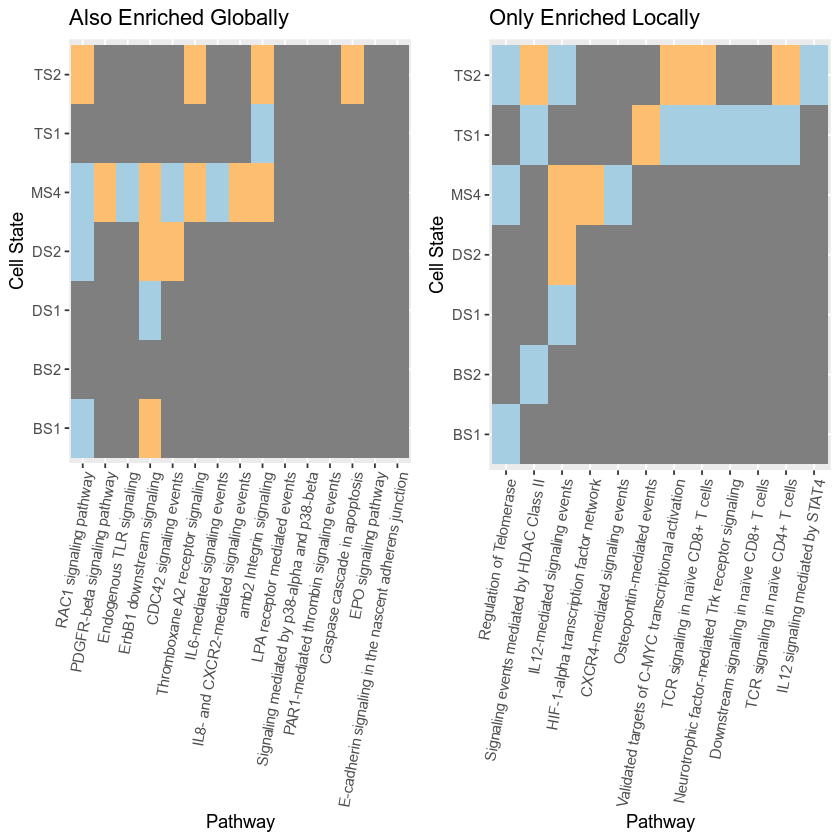

In [123]:
# Color scheme
# 1 -> orange -> w/r/t state
# 0.5 -> blue -> w/r/t type

grid.arrange(p_global + theme(axis.text.x = element_text(angle = 80, hjust=1), legend.position = "none"),
             p_local + theme(axis.text.x = element_text(angle = 80, hjust=1), legend.position = "none"), 
             ncol=2)
g <- arrangeGrob(p_global + theme(axis.text.x = element_text(angle = 80, hjust=1), legend.position = "none"),
             p_local + theme(axis.text.x = element_text(angle = 80, hjust=1), legend.position = "none"), 
             ncol=2) #generates g
ggsave(file='../_figs/suppfig.sepsis.local_enrichment.pdf', g) #saves g
dev.off()

### Save supplemental tables

In [23]:
colnames(enrichment_supptable) = c("Pathway", "Adjusted P-value", "Enrichment", "Comparator", "Population")

In [30]:
enrichment_supptable$Enrichment = round(enrichment_supptable$Enrichment,2)

In [32]:
enrichment_supptable$`Adjusted P-value` = formatC(enrichment_supptable$`Adjusted P-value`, format = "e", digits = 2)

In [38]:
export_filename = "supptable.sepsis.genesets_wrt_cluster.tex"
print(xtable(enrichment_supptable[which(enrichment_supptable$Comparator=="Cluster")], type="latex"), 
      file=paste0(table_destination,export_filename), 
                 floating=FALSE,latex.environments=NULL, include.rownames=FALSE)

In [39]:
export_filename = "supptable.sepsis.genesets_wrt_celltype.tex"
print(xtable(enrichment_supptable[which(enrichment_supptable$Comparator=="Major cell type")], type="latex"), 
      file=paste0(table_destination,export_filename), 
                 floating=FALSE,latex.environments=NULL, include.rownames=FALSE)